<a href="https://colab.research.google.com/github/lucy4Git/Generative-Chatbot-for-Poultry-Management-Information-System/blob/main/Retina_Vessel_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Retinal Blood Vessel Segmentation - 242689917 - Aziz_ Niyi NOI

##  Steps
- Load and Preprocess Data
-Model Training and Evaluation
-Data Visualization
-Performance Comparison

##Importing Libraries

In [ ]:
!pip install imantics --quiet

  Preparing metadata (setup.py) ... done


In [ ]:
import os
import cv2
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import imantics
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Load and Preprocess Data



In [ ]:
import zipfile
import os # Import the os module

zip_file_path = '/content/drive/MyDrive/GA1/Retinal_Blood_Vessel_Segmentation.zip'
extract_path = '/content/extracted_data'  # Define the extraction path


# Use 'zip_file_path' instead of 'zip_path'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Set the correct directories based on unzipped content
# The extracted folder might be directly under 'extract_path'
data_dir = extract_path  # Changed to directly use extract_path

# List the contents of the extracted data_dir to check folder names
extracted_folders = os.listdir(data_dir)
print("Extracted folders:", extracted_folders)


Extracted folders: ['Data']


In [ ]:
# Corrected image and mask paths
images_dir = '/content/extracted_data/Data/train/image'
masks_dir = '/content/extracted_data/Data/train/mask'

# Get list of files
images_listdir = os.listdir(images_dir)
masks_listdir = os.listdir(masks_dir)

print("Number of images:", len(images_listdir))
print("Number of masks:", len(masks_listdir))


Number of images: 80
Number of masks: 80


In [ ]:
# Pick a random image
# Define random_images before the loop
import random
import os # Make sure os is imported

random_image_name = np.random.choice(images_listdir)
image_path = os.path.join(images_dir, random_image_name)

image_size=512
input_image_size=(512,512)

# Read the image
def read_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

number=200


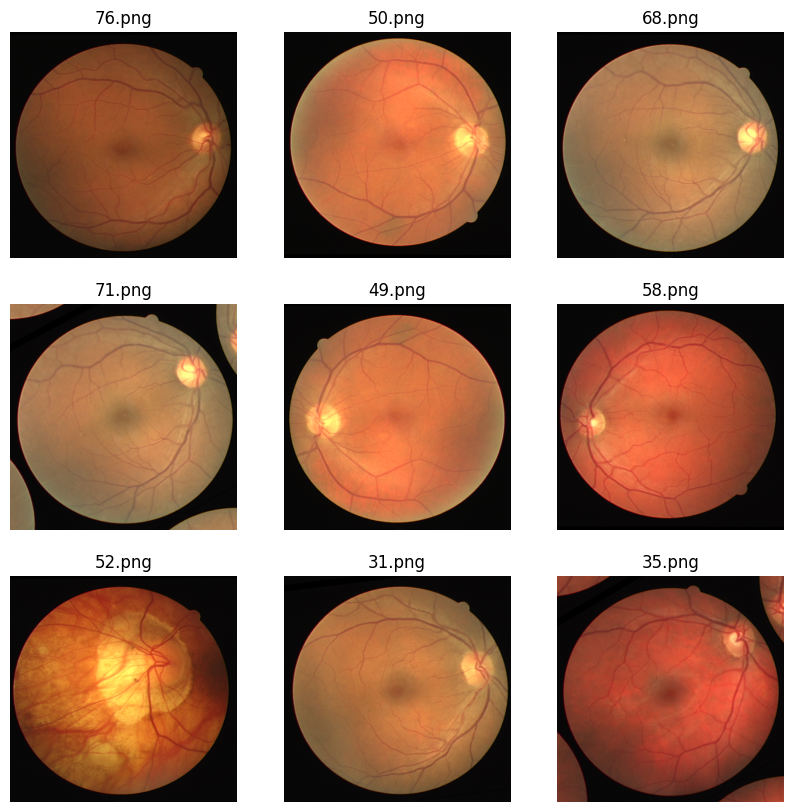

In [ ]:
rows = 3
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (10,10))

# Define random_images before the loop
import random
import os # Make sure os is imported

random_images = random.sample(os.listdir(images_dir), rows * cols)  # Select random images

for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        img = read_image(f"{images_dir}/{random_images[i]}")
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')

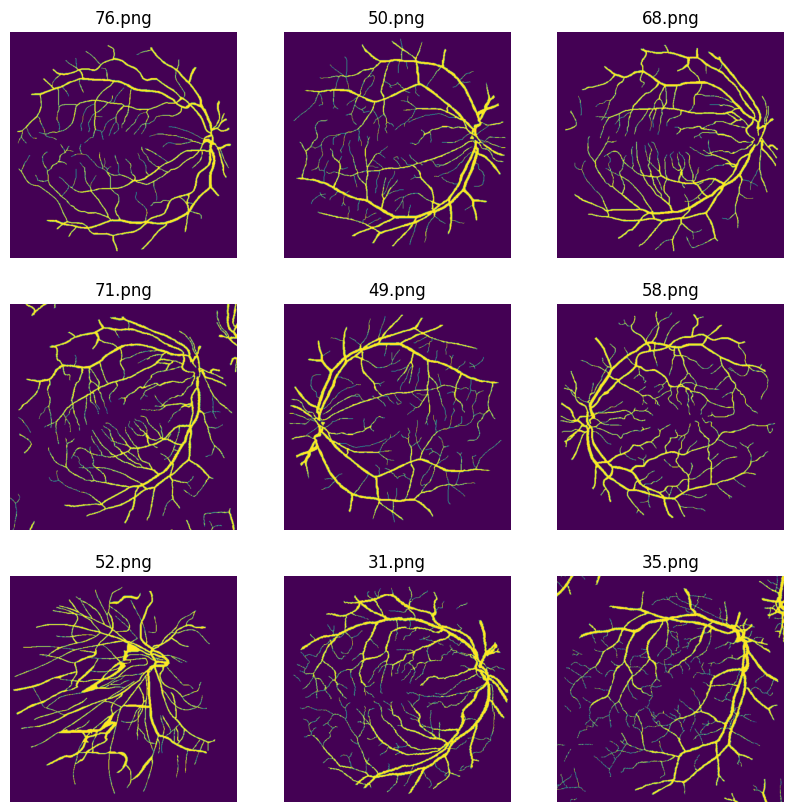

In [ ]:
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        file=random_images[i]
        if os.path.exists(os.path.join(masks_dir,file)):
            img = read_image(f"{masks_dir}/{file}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ax.set_title(f"{random_images[i]}")
            ax.imshow(img)
            ax.axis('off')
        else:
            print('not exist')

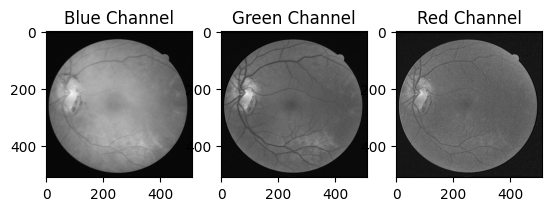

In [ ]:
# Split the image into RGB channels
# Assuming 'image_path' is defined as in previous cell and holds the path to your image
image = cv2.imread(image_path) # Load the image using cv2.imread
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert to RGB format if necessary
blue_channel, green_channel, red_channel = cv2.split(image)

# Save each channel as a separate image
cv2.imwrite('/content/extracted_data/Retinal_blue_channel.png', blue_channel)
cv2.imwrite('/content/extracted_data/Retinal_green_channel.png', green_channel)
cv2.imwrite('/content/extracted_data/Retinal_red_channel.png', red_channel)

# Display each channel
plt.subplot(1, 3, 1)
plt.imshow(blue_channel, cmap='gray')
plt.title('Blue Channel')

plt.subplot(1, 3, 2)
plt.imshow(green_channel, cmap='gray')
plt.title('Green Channel')

plt.subplot(1, 3, 3)
plt.imshow(red_channel, cmap='gray')
plt.title('Red Channel')

plt.show()

In [ ]:
MASKS=np.zeros((1,image_size, image_size, 1), dtype=bool)
IMAGES=np.zeros((1,image_size, image_size, 3),dtype=np.uint8)

for j,file in enumerate(images_listdir[0:number]):   ##the smaller, the faster
    try:
        image = read_image(f"{images_dir}/{file}")
        image_ex = np.expand_dims(image, axis=0)
        IMAGES = np.vstack([IMAGES, image_ex])
        mask = read_image(f"{masks_dir}/{file}")
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask.reshape(512,512,1)
        mask_ex = np.expand_dims(mask, axis=0)
        MASKS = np.vstack([MASKS, mask_ex])
    except:
        print(file)
        continue

In [ ]:
images=np.array(IMAGES)[1:number+1]
masks=np.array(MASKS)[1:number+1]
print(images.shape,masks.shape)

(80, 512, 512, 3) (80, 512, 512, 1)


In [ ]:
images_train, images_test, masks_train, masks_test = train_test_split(
    images, masks, test_size=0.4, random_state=42)

In [ ]:
print(len(images_train), len(masks_train))

48 48


# Model Training and Evaluation

# Custom U-Net

In [ ]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 --quiet

import os
import gc # Import the garbage collector
import cv2

# Import necessary libraries from PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F

import matplotlib.pyplot as plt

# Create checkpoint directory
os.makedirs("checkpoints", exist_ok=True)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reduced image size
image_size = 16
input_image_size = (image_size, image_size)

# Function to read and resize images
def read_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, input_image_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


In [ ]:
# ------------------- Dataset -------------------
class SegmentationDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx], dtype=torch.float32).permute(2, 0, 1) / 255.0 # Changed to torch.float32
        mask = torch.tensor(self.masks[idx], dtype=torch.float32) / 255.0 # Changed to torch.float32 # Remove extra dimension
        mask = mask.squeeze().type(torch.float32) # Changed to torch.float32

        return image, mask

In [ ]:
# ------------------- Metrics -------------------
def compute_iou(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + 1e-6) / (union + 1e-6)

def compute_dice(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum()
    return (2. * intersection + 1e-6) / (pred.sum() + target.sum() + 1e-6)


In [ ]:
# ------------------- Training -------------------
dataset = SegmentationDataset(images_train, masks_train)
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Reduce batch size even more
batch_size = 1 # Reduce this if necessary - try 1

# Use gradient accumulation to simulate larger batch size without increasing memory usage
gradient_accumulation_steps = 8 # Increased from 4 to 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# Reduced the size of the UNet Model, by reducing the number of filters. This helps in memory efficiency by
# reducing the number of trainable parameters for a given input size.
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, bias=False), # Set bias=False for Conv2d layers
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False), # Set bias=False for Conv2d layers
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )


        self.enc1 = conv_block(in_channels, 32) # Reduced from 64 to 32
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(32, 64) # Reduced from 128 to 64
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(64, 128) # Reduced from 256 to 128
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = conv_block(128, 256) # Reduced from 512 to 256
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = conv_block(256, 512) # Reduced from 1024 to 512

        self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec4 = conv_block(512, 256)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = conv_block(256, 128)
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = conv_block(128, 64)
        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec1 = conv_block(64, 32)

        self.final = nn.Conv2d(32, out_channels, kernel_size=1) # Reduced from 64 to 32

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        enc4 = self.enc4(self.pool3(enc3))
        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = self.dec4(torch.cat([dec4, enc4], dim=1))
        dec3 = self.upconv3(dec4)
        dec3 = self.dec3(torch.cat([dec3, enc3], dim=1))
        dec2 = self.upconv2(dec3)
        dec2 = self.dec2(torch.cat([dec2, enc2], dim=1))
        dec1 = self.upconv1(dec2)
        dec1 = self.dec1(torch.cat([dec1, enc1], dim=1))

        return self.final(dec1)

# ... (UNet class) ...
custom_model = UNet(in_channels=3, out_channels=1).to(device)
optimizer_custom = torch.optim.Adam(custom_model.parameters(), lr=1e-4)
criterion_custom = nn.BCEWithLogitsLoss()

# Wrap the model and optimizer with amp:
#custom_model, optimizer_custom = amp.initialize(custom_model, optimizer_custom, opt_level="O1")


In [ ]:
# Metric history
history = {
    "train_loss": [], "val_loss": [],
    "train_iou": [], "val_iou": [],
    "train_dice": [], "val_dice": []
}

num_epochs = 20
for epoch in range(num_epochs):
    custom_model.train()
    train_loss = train_iou = train_dice = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = custom_model(images)

        # Reshape masks to add channel dimension before calculating loss
        masks = masks.unsqueeze(1)  # Add channel dimension to match the output shape

        loss = criterion_custom(outputs, masks)

        optimizer_custom.zero_grad()
        loss.backward()
        optimizer_custom.step()

        preds = torch.sigmoid(outputs)
        train_loss += loss.item()
        train_iou += compute_iou(preds, masks).item()
        train_dice += compute_dice(preds, masks).item()


    custom_model.eval()
    val_loss = val_iou = val_dice = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = custom_model(images)

            # Add channel dimension to masks here as well:
            masks = masks.unsqueeze(1) # Add channel dimension to match the output shape

            loss = criterion_custom(outputs, masks)

            preds = torch.sigmoid(outputs)
            val_loss += loss.item()
            val_iou += compute_iou(preds, masks).item()
            val_dice += compute_dice(preds, masks).item()

    # Store epoch metrics
    history["train_loss"].append(train_loss / len(train_loader))
    history["val_loss"].append(val_loss / len(val_loader))
    history["train_iou"].append(train_iou / len(train_loader))
    history["val_iou"].append(val_iou / len(val_loader))
    history["train_dice"].append(train_dice / len(train_loader))
    history["val_dice"].append(val_dice / len(val_loader))

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {history['train_loss'][-1]:.4f}, IoU: {history['train_iou'][-1]:.4f}, Dice: {history['train_dice'][-1]:.4f} | "
          f"Val Loss: {history['val_loss'][-1]:.4f}, IoU: {history['val_iou'][-1]:.4f}, Dice: {history['val_dice'][-1]:.4f}")

    # Clear memory after each iteration - Moved outside the 'with' block
    del images, masks, outputs, loss, preds
    gc.collect() # Run garbage collection
    torch.cuda.empty_cache()  # Empty the CUDA cache - use with caution, can slow down training

Epoch [1/20] Train Loss: 0.4583, IoU: 0.3089, Dice: 0.4565 | Val Loss: 0.4074, IoU: 0.0166, Dice: 0.0323
Epoch [2/20] Train Loss: 0.3599, IoU: 0.4916, Dice: 0.6569 | Val Loss: 0.3643, IoU: 0.3474, Dice: 0.4859
Epoch [3/20] Train Loss: 0.3279, IoU: 0.5403, Dice: 0.7001 | Val Loss: 0.3342, IoU: 0.4003, Dice: 0.5569
Epoch [4/20] Train Loss: 0.3076, IoU: 0.5634, Dice: 0.7194 | Val Loss: 0.3405, IoU: 0.3889, Dice: 0.5351
Epoch [5/20] Train Loss: 0.2917, IoU: 0.5782, Dice: 0.7318 | Val Loss: 0.3093, IoU: 0.4261, Dice: 0.5802
Epoch [6/20] Train Loss: 0.2775, IoU: 0.5902, Dice: 0.7415 | Val Loss: 0.2863, IoU: 0.4411, Dice: 0.5897
Epoch [7/20] Train Loss: 0.2651, IoU: 0.5990, Dice: 0.7487 | Val Loss: 0.2832, IoU: 0.4303, Dice: 0.5742
Epoch [8/20] Train Loss: 0.2541, IoU: 0.6065, Dice: 0.7545 | Val Loss: 0.2697, IoU: 0.4628, Dice: 0.6153
Epoch [9/20] Train Loss: 0.2434, IoU: 0.6153, Dice: 0.7614 | Val Loss: 0.2690, IoU: 0.4714, Dice: 0.6216
Epoch [10/20] Train Loss: 0.2340, IoU: 0.6190, Dice: 0.

In [ ]:
# ------------------- Plot Curves -------------------
#def plot_metric(train_values, val_values, metric_name):
    #plt.figure()
    #plt.plot(train_values, label=f'Train {metric_name}')
    #plt.plot(val_values, label=f'Val {metric_name}')
    #plt.xlabel('Epoch')
    #plt.ylabel(metric_name)
    #plt.title(f'{metric_name} per Epoch')
    #plt.legend()
    #plt.grid(True)
    #plt.show()

#plot_metric(history['train_loss'], history['val_loss'], 'Loss')
#plot_metric(history['train_iou'], history['val_iou'], 'IoU')
#plot_metric(history['train_dice'], history['val_dice'], 'Dice')


In [ ]:
def show_predictions(model, dataset, num_samples=5, threshold=0.5):
    model.eval()
    fig, axs = plt.subplots(num_samples, 3, figsize=(10, 5 * num_samples))

    for i in range(num_samples):
        image, mask = dataset[i]
        image_input = image.unsqueeze(0).to(device)
        with torch.no_grad():
            pred = torch.sigmoid(model(image_input)).squeeze().cpu().numpy()

        image_np = image.permute(1, 2, 0).numpy()
        mask_np = mask.numpy()
        pred_mask = (pred > threshold).astype(np.uint8)

        # Plot Original, Prediction, Ground Truth
        axs[i, 0].imshow(image_np)
        axs[i, 0].set_title('Original Image')
        axs[i, 0].axis('off')

        axs[i, 1].imshow(pred_mask, cmap='gray')
        axs[i, 1].set_title('Predicted Mask (U-Net)')
        axs[i, 1].axis('off')

        axs[i, 2].imshow(mask_np, cmap='gray')
        axs[i, 2].set_title('Ground Truth Mask')
        axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()


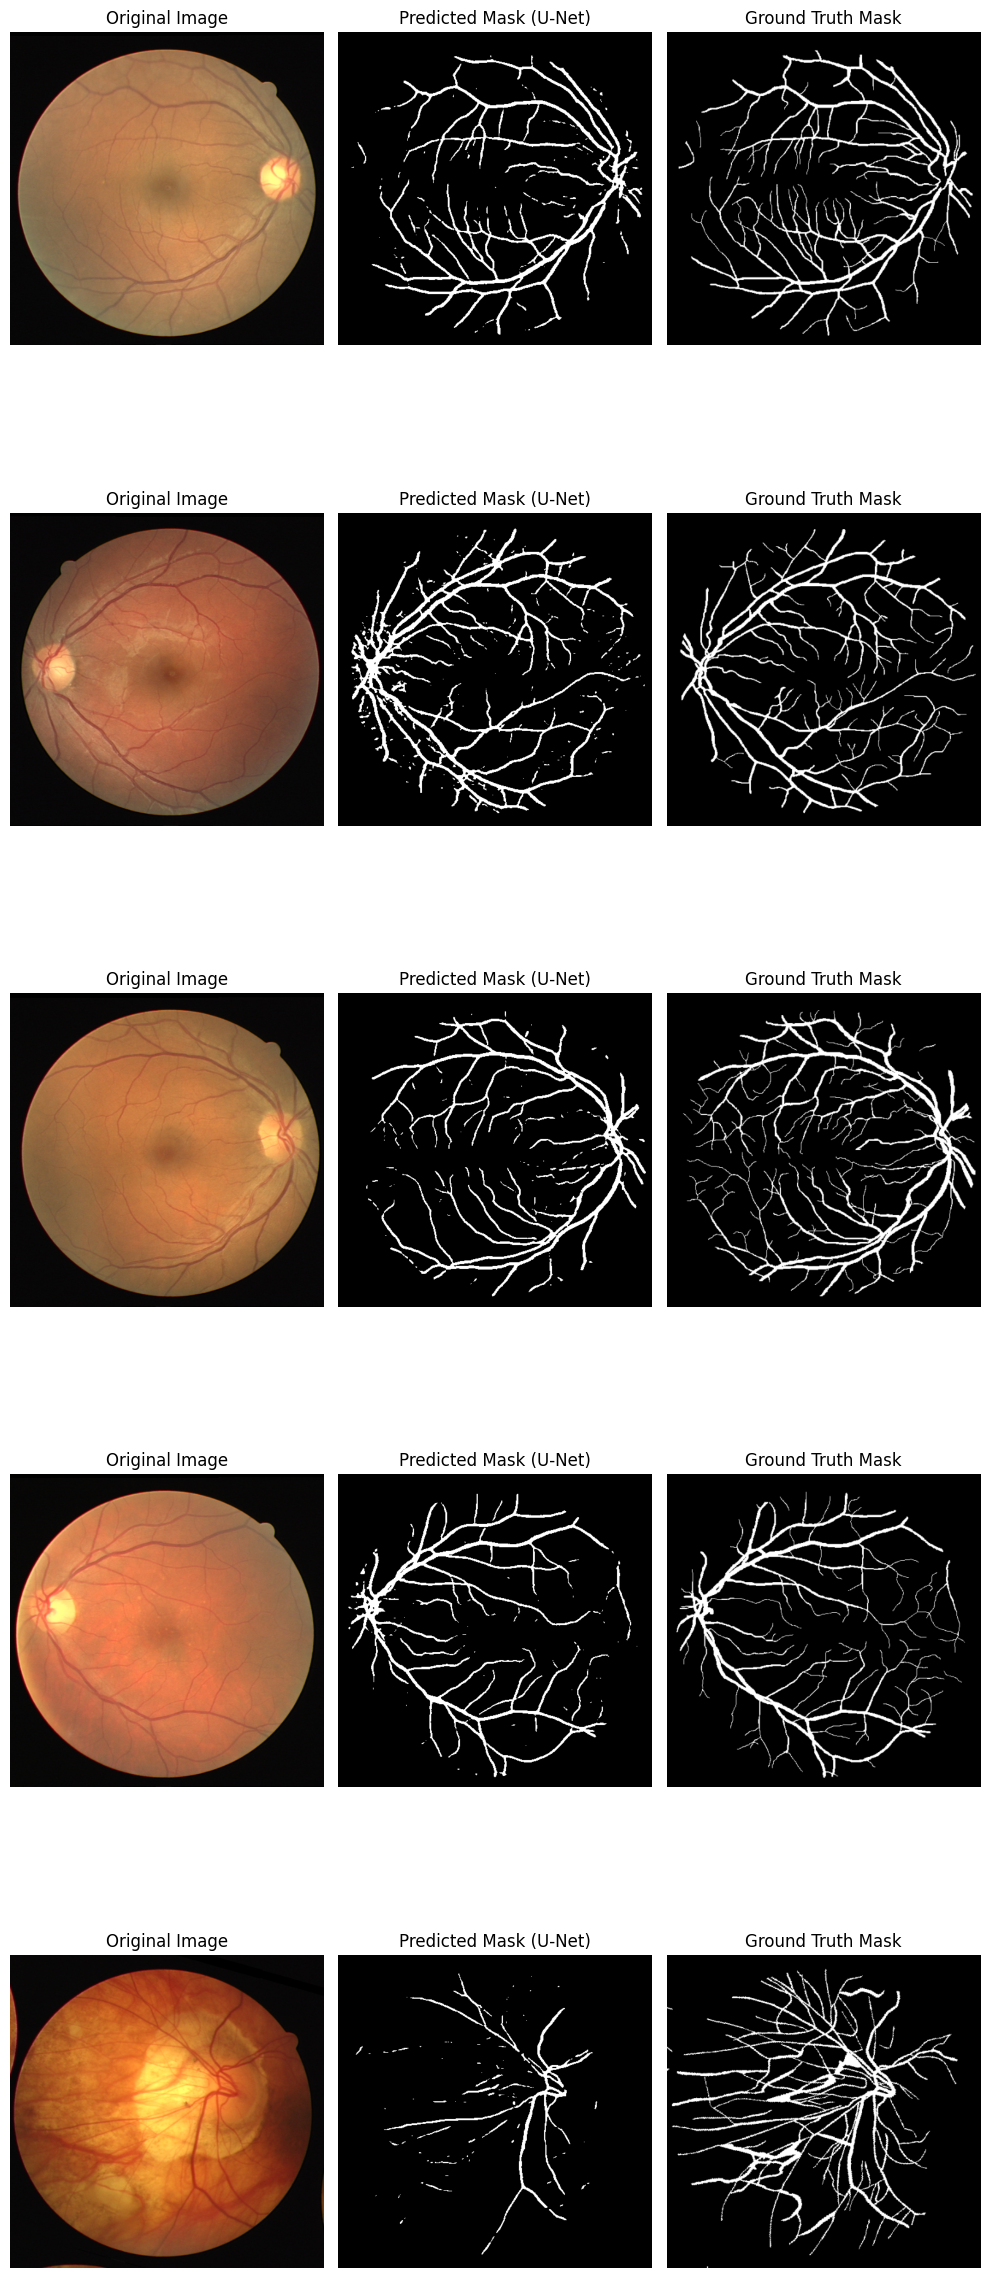

In [ ]:
# Show predictions on validation set
show_predictions(custom_model, val_dataset, num_samples=5)


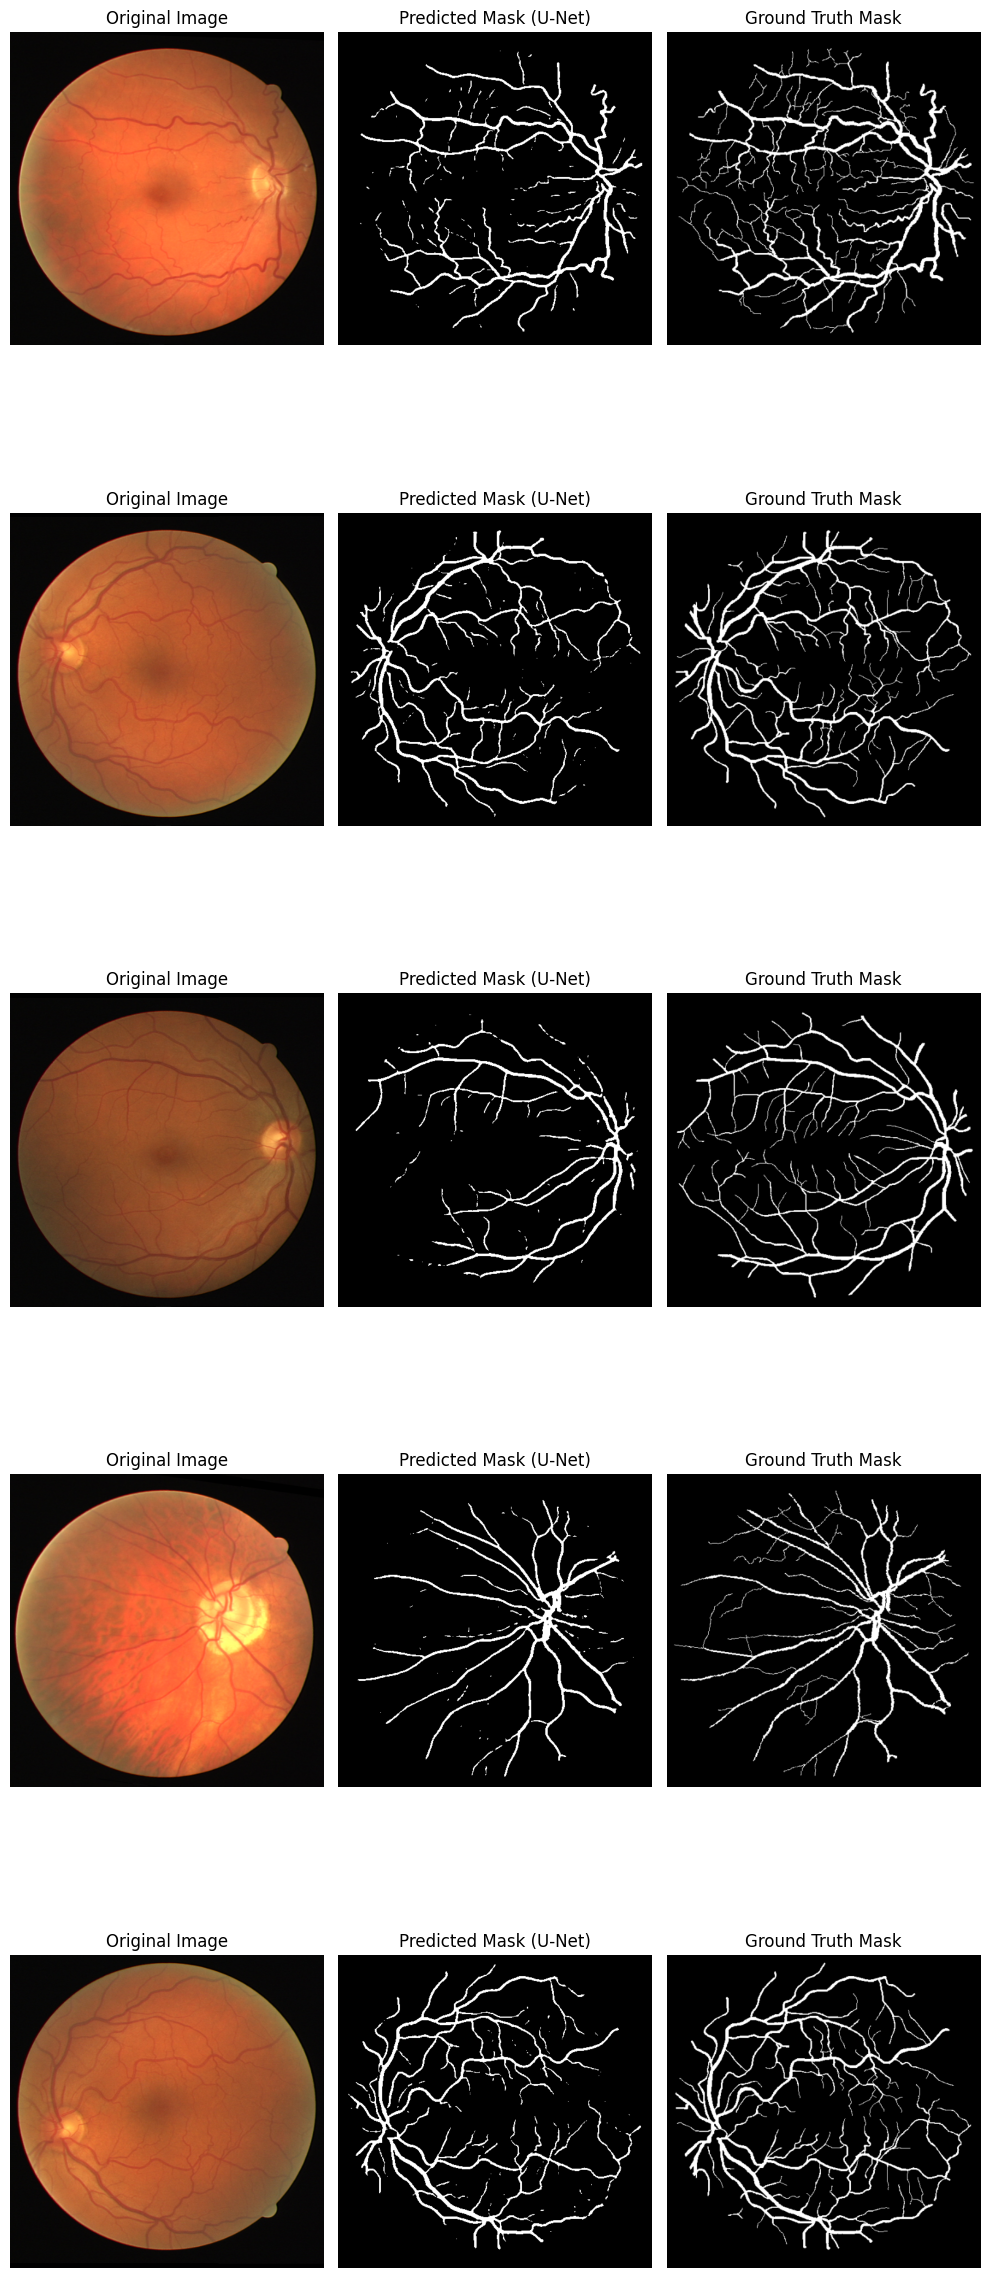

In [ ]:
show_predictions(custom_model, train_dataset, num_samples=5)


In [ ]:
import numpy as np
from PIL import Image

def save_predictions(model, dataset, save_dir='predictions', num_samples=5, threshold=0.5):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()

    for i in range(num_samples):
        image, mask = dataset[i]
        image_input = image.unsqueeze(0).to(device)

        with torch.no_grad():
            pred = torch.sigmoid(model(image_input)).squeeze().cpu().numpy()

        image_np = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        mask_np = (mask.numpy() * 255).astype(np.uint8)
        pred_mask = ((pred > threshold) * 255).astype(np.uint8)

        # Save original image
        Image.fromarray(image_np).save(os.path.join(save_dir, f'image_{i}.png'))

        # Save predicted mask
        Image.fromarray(pred_mask).save(os.path.join(save_dir, f'predicted_mask_{i}.png'))

        # Save ground truth mask
        Image.fromarray(mask_np).save(os.path.join(save_dir, f'ground_truth_mask_{i}.png'))

    print(f"Saved {num_samples} predictions to '{save_dir}/'")


In [ ]:
# Save predictions from validation dataset
save_predictions(custom_model, val_dataset, save_dir='predictions', num_samples=5)


Saved 5 predictions to 'predictions/'


In [ ]:
save_predictions(custom_model, train_dataset, save_dir='train_predictions', num_samples=5)


Saved 5 predictions to 'train_predictions/'


# Pretrained U-Net

In [ ]:
!pip install segmentation-models-pytorch --quiet
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.9 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp
from PIL import Image
import matplotlib.pyplot as plt
import glob # Import the glob module

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_paths = sorted(
            glob.glob(os.path.join(image_dir, '*.png'))
        )
        self.mask_paths = sorted(
            glob.glob(os.path.join(mask_dir, '*.png'))
        )
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")  # grayscale

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

train_dataset = SegmentationDataset(
    image_dir='/content/extracted_data/Data/train/image',
    mask_dir='/content/extracted_data/Data/train/mask',
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)


In [ ]:
model = smp.Unet(
    encoder_name="resnet34",        # encoder: ResNet-34
    encoder_weights="imagenet",     # use ImageNet pretraining
    in_channels=3,                  # RGB images
    classes=1                       # binary segmentation (1 channel mask)
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [ ]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
def iou_score(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum((1, 2, 3))
    union = preds.sum((1, 2, 3)) + targets.sum((1, 2, 3)) - intersection
    return (intersection / (union + 1e-6)).mean().item()

def dice_score(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum((1, 2, 3))
    return (2. * intersection / (preds.sum((1, 2, 3)) + targets.sum((1, 2, 3)) + 1e-6)).mean().item()


In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import jaccard_score
import numpy as np

num_epochs = 20

def compute_iou(preds, masks):
    # Convert predictions to binary values before calculating IoU
    preds = (preds > 0.5).int() # Convert to 0 or 1
    preds = preds.view(-1).cpu().numpy()
    masks = masks.int() # Convert masks to int type
    masks = masks.view(-1).cpu().numpy()
    return jaccard_score(masks, preds, zero_division=1)

def compute_dice(preds, masks):
    preds = preds.view(-1)
    masks = masks.view(-1)
    intersection = (preds * masks).sum()
    return (2. * intersection) / (preds.sum() + masks.sum() + 1e-8)


for epoch in range(num_epochs):
    # TRAINING
    model.train()
    train_loss = 0.0
    train_iou = 0.0
    train_dice = 0.0
    n_train = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        # Ensure the mask has the correct shape (B, 1, H, W) after loading:
        # Check the shape and add a channel dimension only if necessary
        if len(masks.shape) == 3:
            masks = masks.unsqueeze(1).float()  # Add channel dimension if missing
        else:
            masks = masks.float()  # Convert to float if already has channel dimension


        optimizer.zero_grad()
        outputs = model(images)

        # Calculate loss without extra unsqueeze
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = torch.sigmoid(outputs) > 0.5
        train_iou += compute_iou(preds, masks)
        train_dice += compute_dice(preds, masks)
        n_train += 1

    # VALIDATION
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    val_dice = 0.0
    n_val = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)

            # Similar to the training loop, ensure the mask has the correct shape:
            if len(masks.shape) == 3:
                masks = masks.unsqueeze(1).float()  # Add channel dimension if missing
            else:
                masks = masks.float()  # Convert to float if already has channel dimension


            outputs = model(images)

            # Calculate loss without extra unsqueeze
            loss = criterion(outputs, masks)

            val_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5
            val_iou += compute_iou(preds, masks)
            val_dice += compute_dice(preds, masks)
            n_val += 1

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss/n_train:.4f}, IOU: {train_iou/n_train:.4f}, Dice: {train_dice/n_train:.4f}")
    print(f"Val   Loss: {val_loss/n_val:.4f}, IOU: {val_iou/n_val:.4f}, Dice: {val_dice/n_train:.4f}")

Epoch [1/20]
Train Loss: 0.4529, IOU: 0.0219, Dice: 0.1865
Val   Loss: 0.4322, IOU: 0.0498, Dice: 0.0399
Epoch [2/20]
Train Loss: 0.3790, IOU: 0.0583, Dice: 0.1838
Val   Loss: 0.3121, IOU: 0.0439, Dice: 0.0295
Epoch [3/20]
Train Loss: 0.3333, IOU: 0.0960, Dice: 0.2286
Val   Loss: 0.2835, IOU: 0.0535, Dice: 0.0331
Epoch [4/20]
Train Loss: 0.3014, IOU: 0.1161, Dice: 0.3285
Val   Loss: 0.2609, IOU: 0.1159, Dice: 0.0682
Epoch [5/20]
Train Loss: 0.2769, IOU: 0.1204, Dice: 0.4035
Val   Loss: 0.2426, IOU: 0.1776, Dice: 0.0998
Epoch [6/20]
Train Loss: 0.2584, IOU: 0.1171, Dice: 0.4633
Val   Loss: 0.2294, IOU: 0.2112, Dice: 0.1159
Epoch [7/20]
Train Loss: 0.2427, IOU: 0.1145, Dice: 0.5054
Val   Loss: 0.2188, IOU: 0.2608, Dice: 0.1406
Epoch [8/20]
Train Loss: 0.2294, IOU: 0.1082, Dice: 0.5420
Val   Loss: 0.2067, IOU: 0.3276, Dice: 0.1747
Epoch [9/20]
Train Loss: 0.2182, IOU: 0.1055, Dice: 0.5649
Val   Loss: 0.1990, IOU: 0.3459, Dice: 0.1828
Epoch [10/20]
Train Loss: 0.2088, IOU: 0.1022, Dice: 0.

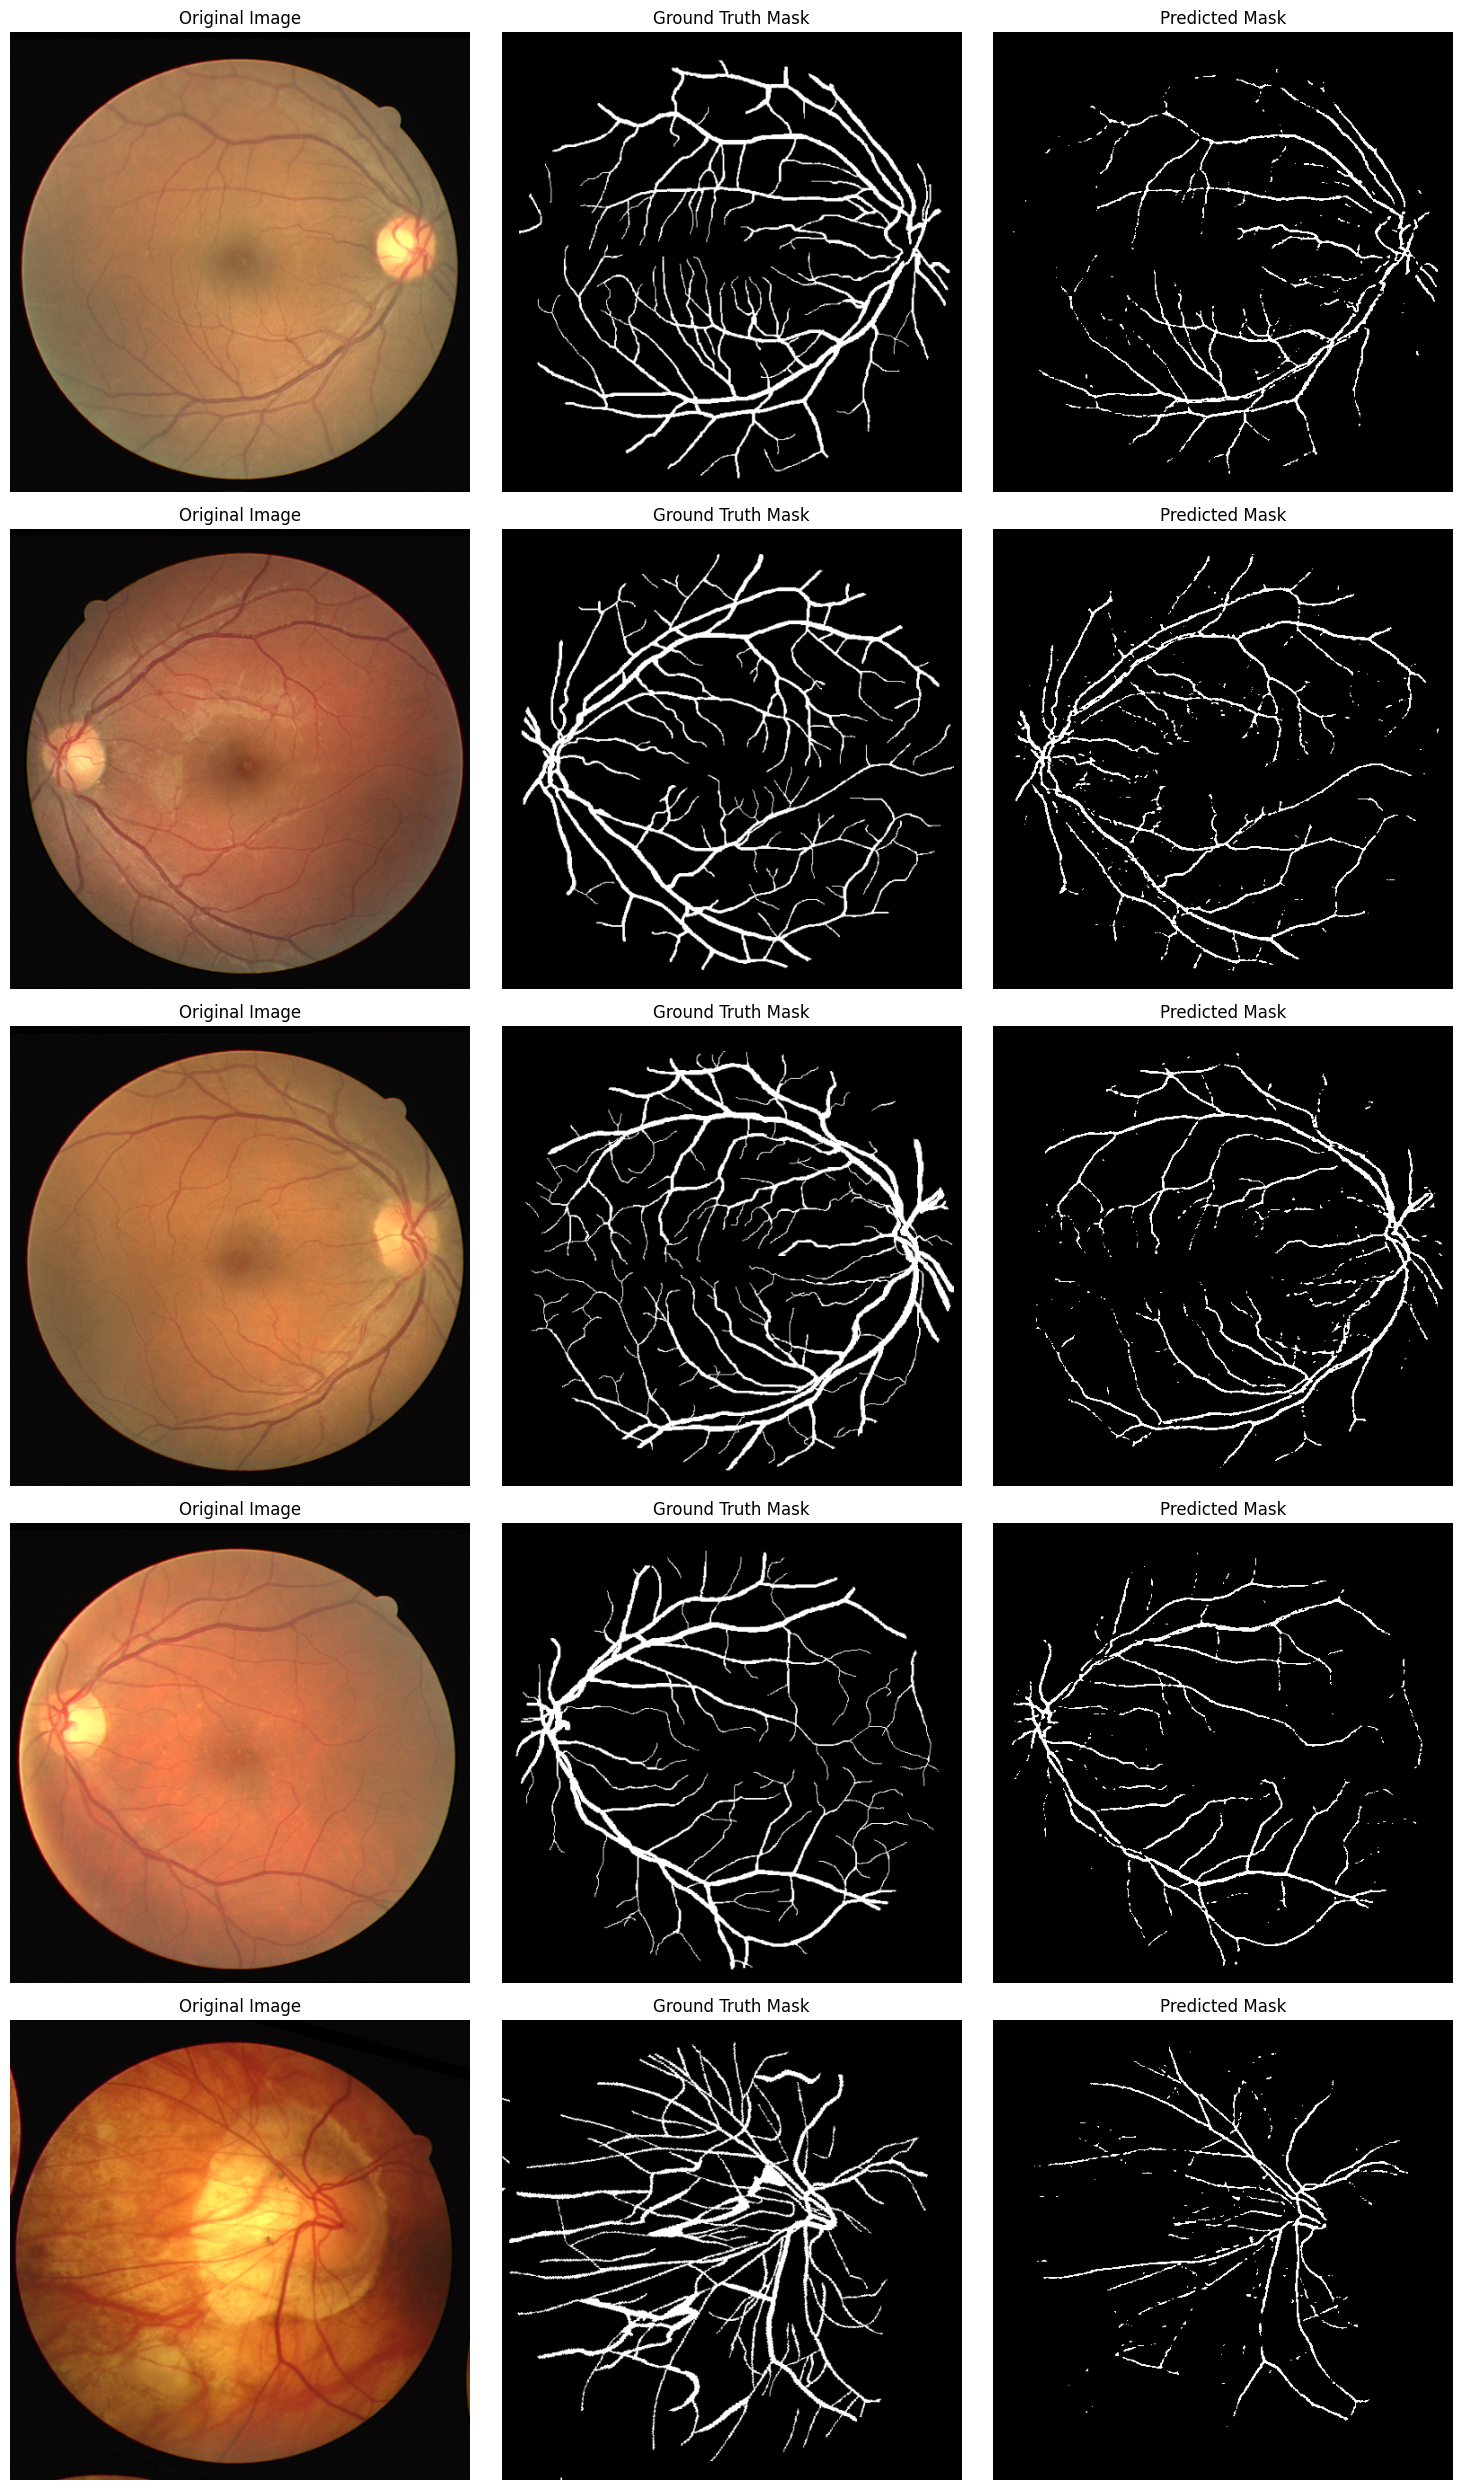

In [ ]:
model.eval()
with torch.no_grad():
    images_list = []
    masks_list = []
    preds_list = []

    # Collect data for 5 images
    for batch_idx, (images, masks) in enumerate(val_loader):
        if batch_idx >= 5:  # Stop after collecting data for 5 images
            break

        images = images.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs)
        preds = preds > 0.5

        images_list.extend(images.cpu())
        masks_list.extend(masks.cpu())
        preds_list.extend(preds.cpu())

    # Display the collected images
    plt.figure(figsize=(15, 5 * 5))  # Adjust figure size for 5 images
    for i in range(5):
        image_np = images_list[i].permute(1, 2, 0).numpy()
        mask_np = masks_list[i].numpy()
        pred_mask = preds_list[i][0].numpy()  # Get the first channel of the prediction

        plt.subplot(5, 3, i * 3 + 1)
        plt.imshow(image_np)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(5, 3, i * 3 + 2)
        plt.imshow(mask_np, cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        plt.subplot(5, 3, i * 3 + 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
import os
import numpy as np
from PIL import Image

def save_predictions(model, dataset, save_dir='predictions', num_samples=5, threshold=0.5):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()

    for i in range(num_samples):
        image, mask = dataset[i]
        image_input = image.unsqueeze(0).to(device)

        with torch.no_grad():
            pred = torch.sigmoid(model(image_input)).squeeze().cpu().numpy()

        image_np = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)

        # Convert mask_np to uint8 before saving
        mask_np = (mask.numpy() * 255).astype(np.uint8)
        pred_mask = ((pred > threshold) * 255).astype(np.uint8)

        # Save original image
        Image.fromarray(image_np).save(os.path.join(save_dir, f'image_{i}.png'))

        # Save predicted mask
        Image.fromarray(pred_mask).save(os.path.join(save_dir, f'predicted_mask_{i}.png'))

        # Save ground truth mask - ensure it's 2D and uint8
        Image.fromarray(mask_np.squeeze()).save(os.path.join(save_dir, f'ground_truth_mask_{i}.png'))

    print(f"Saved {num_samples} predictions to '{save_dir}/'")

In [ ]:
# Save predictions from validation dataset
save_predictions(model, val_dataset, save_dir='predictions_pretrain', num_samples=5)

# Save predictions from train dataset
save_predictions(model, train_dataset, save_dir='train_predictions_pretrain', num_samples=5)

Saved 5 predictions to 'predictions_pretrain/'
Saved 5 predictions to 'train_predictions_pretrain/'


# Comparison Table

In [ ]:
#import pandas as pd
#import matplotlib.pyplot as plt

# Initialize empty lists to store metrics
#custom_dice_list = []
#custom_iou_list = []
#val_dices = []  # Renamed for consistency (previously val_dice_list)
#val_ious = []   # Renamed for consistency (previously val_iou_list)

# ... (Your training loops for custom and pretrained models,
# where you append values to these lists) ...

# Create the DataFrame with checks for empty lists
#if not any(len(lst) for lst in [custom_dice_list, custom_iou_list, val_dices, val_ious]):
    #print("Metric lists are empty. Please run the training loops to collect metrics.")
    # Create an empty DataFrame or handle it differently based on your preference
    #comparison_df = pd.DataFrame(columns=["Epoch", "Custom Dice", "Custom IoU", "Pretrained Dice", "Pretrained IoU"])
#else:
    # Ensure all metric lists have the same length (number of epochs)
    #num_epochs = min(len(custom_dice_list), len(custom_iou_list), len(val_dices), len(val_ious))

    # Create the DataFrame if metric lists are not empty
    #comparison_df = pd.DataFrame({
        #"Epoch": list(range(1, num_epochs + 1)),
        #"Custom Dice": custom_dice_list[:num_epochs],
        #"Custom IoU": custom_iou_list[:num_epochs],
        #"Pretrained Dice": val_dices[:num_epochs],
        #"Pretrained IoU": val_ious[:num_epochs]
    #})

# Plotting the comparison
#plt.figure(figsize=(10, 6))
#plt.plot(comparison_df["Epoch"], comparison_df["Custom Dice"], label="Custom Dice")
#plt.plot(comparison_df["Epoch"], comparison_df["Custom IoU"], label="Custom IoU")
#plt.plot(comparison_df["Epoch"], comparison_df["Pretrained Dice"], label="Pretrained Dice")
#plt.plot(comparison_df["Epoch"], comparison_df["Pretrained IoU"], label="Pretrained IoU")

#plt.title("Model Metric Comparison")
#plt.xlabel("Epoch")
#plt.ylabel("Score")
#plt.legend()
#plt.grid(True)
#plt.show()

# Displaying the table
#print(comparison_df)